Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [1]:
NAME = "Anuj Gupta"
ID = "st122561"

---

# Machine Learning Lab 04: Multinomial Logistic Regression


## Generalized Linear Models

From lecture, we know that members of the exponential family distributions can be written in the form
$$p(y;\eta) = b(y)e^{(\eta^\top T(y)-a(\eta))},$$
where
- $\eta$ is the natural parameter or canonical paramter of the distribution,
- $T(y)$ is the sufficient statistic (we normally use $T(y) = y$),
- $b(y)$ is an arbitrary scalar function of y, and
- $a(\eta)$ is the log partition function. We use $e^{a(\eta)}$ just to normalize the distribution to have a sum or integral of 1.

Each choice of $T$, $a$, and $b$ defines a family (set) of distributions parameterized by $\eta$.

If we can write $p(y \mid \mathbf{x} ; \theta)$ as a member of the exponential family of distributions with parameters $\mathbf{\eta}$ with
$\eta_i = \theta^\top_i \mathbf{x}$, we obtain a *generalized linear model* that can be optimized using the maximum likelihood principle.

The GLM for the Gaussian distribution with natural parameter $\eta$ being the mean of the Gaussian gives us ordinary linear regression.

The Bernoulli distribution with parameter $\phi$ can be written as an exponential distribution
with natural parmeter $\eta = \log \frac{\phi}{1-\phi}$. The GLM for this distribution is logistic regression.

When we write the multinomial distribution with paremeters $\phi_i > 0$ for classes $i \in 1..K$ with the constraint that
$$\sum_{i=1}^{K} \phi_i = 1$$ as a member of the exponential family,
the resulting GLM is called *multinomial logistic regression*. The parameters $\phi_1, \ldots, \phi_K$ are written
in terms of $\theta$ as
$$\phi_i = p(y = i \mid \mathbf{x}; \theta) = \frac{e^{\theta^\top_i \mathbf{x}}}{\sum_{j=1}^{K}e^{\theta^\top_j \mathbf{x}}}. $$

## Optimizing a Multinomial Regression Model

In multinomial regression, we have

1. Data are pairs $\mathbf{x}^{(i)}, y^{(i)}$ with $\mathbf{x}^{(i)} \in \mathbb{R}^n$ and
   $y \in 1..K$.
   
2. The hypothesis is a vector-valued function
$$\mathbf{h}_\theta(\mathbf{x}) = \begin{bmatrix} p(y = 1 \mid \mathbf{x} ; \theta) \\
                                         p(y = 2 \mid \mathbf{x} ; \theta) \\
                                         \vdots \\
                                         p(y = K \mid \mathbf{x} ; \theta) \end{bmatrix},$$
    where $$p(y = i \mid \mathbf{x}) = \phi_i = p(y = i \mid \mathbf{x}; \theta) = \frac{e^{\theta^\top_i \mathbf{x}}}{\sum_{j=1}^{K}e^{\theta^\top_j \mathbf{x}}}. $$

We need a cost function and a way to minimize that cost function. As usual, we try to find the parameters maximizing the likelihood or log likelihood function, or equivalently, minimizing the negative log likelihood function:

$$\theta^* = \text{argmax}_\theta {\cal L}(\theta) =
             \text{argmax}_\theta \ell(\theta) =
             \text{argmin}_\theta J(\theta),$$
where
$$\begin{eqnarray}
   J(\theta) & = & - \ell(\theta) \\
   & = & - \sum_{i=1}^m \log p(y^{(i)} \mid \textbf{x}^{(i)} ; \theta).
   \end{eqnarray}$$

Now that we know what is $J(\theta)$, let's try to find its minimimum by taking the derivatives with respect to an arbitrary parameter $\theta_{kl}$, the $l$-th element of the parameter vector $\theta_k$ for class $k$. Before we start, let's define a variable $a_k$ as the linear activation for class $k$ in the softmax function:
$$ a_k = \theta_k^\top \mathbf{x}^{(i)}, $$
and rewrite the softmax more conveniently as
$$ \phi_k = \frac{e^{a_k}}{\sum_{j=1}^K e^{a_j}}. $$
That makes it a little easier to compute the gradient:
$$\begin{eqnarray}
   \frac{\partial J}{\partial \theta_{kl}} & = & - \sum_{i=1}^m \frac{1}{\phi_{y^{(i)}}} \frac{\partial \phi_{y^{(i)}}}{\partial \theta_{kl}}. \\
   \end{eqnarray}$$
Using the chain rule, we have
$$\frac{\partial \phi_{y^{(i)}}}{\partial \theta_{kl}} = \sum_{j=1}^K \frac{\partial \phi_{y^{(i)}}}{\partial a_j} \frac{\partial a_j}{\partial \theta_{kl}}$$
The second factor is easy:
$$ \frac{\partial a_j}{\partial \theta_{kl}} = \delta(k=j)x^{(i)}_l. $$
For the first factor, we have
$$\begin{eqnarray}
\frac{\partial \phi_{y^{(i)}}}{\partial a_j}
& = & \frac{ \left[ \delta(y^{(i)}=j)e^{a_j} \sum_{c=1}^K e^{a_c} \right] - e^{a_j} e^{a_j} }{\left[ \sum_{c=1}^K e^{a_c} \right]^2} \\
& = & \delta(y^{(i)}=j) \phi_j - \phi_j^2
\end{eqnarray}$$

Substituting what we've derived into the definition above, we obtain
$$ \frac{\partial J}{\theta_{kl}} = - \sum_{i=1}^m \sum_{j=1}^K (\delta(y^{(i)}=j) - \phi_j) \frac{\partial a_j}{\partial \theta_{kl}}. $$

There are two ways to do the calculation.
In deep neural networks with multinomial outputs, we want to first calculate the $\frac{\partial J}{\partial a_j}$ terms then use them to calculate $\frac{\partial J}{\partial \theta_{kl}}$.

However, if we only have the "single layer" model described up till now, we note
that
$$\frac{\partial a_j}{\partial \theta_{kl}} = \delta(j=k) x^{(i)}_l,$$
so we can simplify as follows:
$$\begin{eqnarray}
  \frac{\partial J}{\theta_{kl}} & = & - \sum_{i=1}^m \sum_{j=1}^K (\delta(y^{(i)}=j) - \phi_j) \frac{\partial a_j}{\partial \theta_{kl}} \\
  & = & - \sum_{i=1}^m \sum_{j=1}^K (\delta(y^{(i)}=j) - \phi_j) \delta(j=k) x^{(i)}_l \\
  & = & - \sum_{i=1}^m (\delta(y^{(i)}=k) - \phi_k) x^{(i)}_l \\
  \end{eqnarray}$$

## Put It Together

OK! Now we have all 4 criteria for our multinomial regression model:

1. Data are pairs $\mathbf{x}^{(i)}, y^{(i)}$ with $\mathbf{x}^{(i)} \in \mathbb{R}^n$ and
   $y \in 1..K$.
   
2. The hypothesis is a vector-valued function
$$\mathbf{h}_\theta(\mathbf{x}) = \begin{bmatrix} p(y = 1 \mid \mathbf{x} ; \theta) \\
                                         p(y = 2 \mid \mathbf{x} ; \theta) \\
                                         \vdots \\
                                         p(y = K \mid \mathbf{x} ; \theta) \end{bmatrix},$$
    where $$p(y = i \mid \mathbf{x}) = \phi_i = p(y = i \mid \mathbf{x}; \theta) = \frac{e^{\theta^\top_i \mathbf{x}}}{\sum_{j=1}^{K}e^{\theta^\top_j \mathbf{x}}}. $$
    
3. The cost function is
   $$J(\theta) = - \sum_{i=1}^m \log p(y^{(i)} \mid \textbf{x}^{(i)})$$
   
4. The optimization algorithm is gradient descent on $J(\theta)$ with the update rule
   $$\theta_{kl}^{(n+1)} \leftarrow \theta_{kl}^{(n)} - \alpha \sum_{i=1}^m (\delta(y^{(i)}=k) - \phi_k) x^{(i)}_l.$$


## Multinomial Regression Example

The following example of multinomial logistic regression is from [Kaggle](https://www.kaggle.com/saksham219/softmax-regression-for-iris-classification).

The data set is the famous [Iris dataset from the UCI machine learning repository](https://archive.ics.uci.edu/ml/datasets/iris).

The data contain 50 samples from each of three classes. Each class refers to a particular species of the iris plant. 
The data include four independent variables:
1. Sepal length in cm
2. Sepal width in cm
3. Petal length in cm
4. Petal width in cm

The target takes on one of three classes:
1. Iris Setosa
2. Iris Versicolour
3. Iris Virginica
   
To predict the target value, we use multinomial logistic regression for $k=3$ classes i.e. $y \in \{ 1, 2, 3 \}$. 

Given $\mathbf{x}$, we would like to predict a probability distribution over the
three outcomes for $y$, i.e., $\phi_1 = p(y=1 \mid \mathbf{x})$, $\phi_2 = p(y=2 \mid \mathbf{x})$, and $\phi_3 = p(y=3 \mid \mathbf{x})$.


In [2]:
# importing libraries
import numpy as np
import pandas as pd 
import random
import math

The `phi` function returns $\phi_i$ for input patterns $\mathtt{X}$ and parameters $\theta$.

In [3]:
def phi(i, theta, X, num_class):
    """
    Here is how to make documentation for your function show up in intellisense.
    Explanation you put here will be shown when you use it.
    
    To get intellisense in your Jupyter notebook:
        - Press 'TAB' after typing a dot (.) to see methods and attributes
        - Press 'Shift+TAB' after typing a function name to see its documentation

    The `phi` function returns phi_i = h_theta(x) for input patterns X and parameters theta.
    
    Inputs:
        i=index of phi
        
        X=input dataset
        
        theta=parameters

    Returns:
        phi_i
    """
    mat_theta = np.matrix(theta[i])
    mat_x = np.matrix(X)
    num = math.exp(np.dot(mat_theta, mat_x.T))
    den = 0
    for j in range(0,num_class):
        mat_theta_j = np.matrix(theta[j])
        den = den + math.exp(np.dot(mat_theta_j, mat_x.T))
    phi_i = num / den
    return phi_i

**Tips for using intellisense: Shift+TAB**

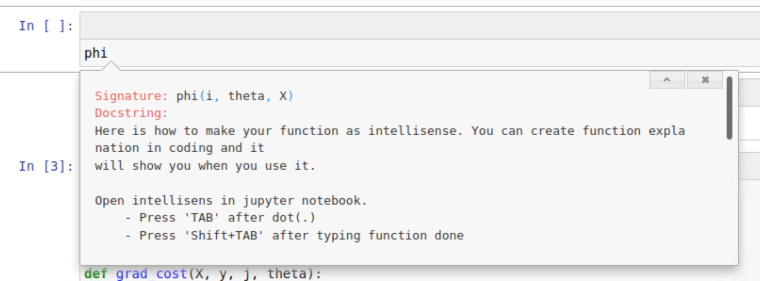

The `grad_cost` function gives the gradient of the cost for data $\mathtt{X}, \mathbf{y}$ for class $j\in 1..k$.

In [4]:
def indicator(i, j):
    '''
    Check whether i is equal to j
    
    Return:
        1 when i=j, otherwise 0
    '''
    if i == j: return 1
    else: return 0


def grad_cost(X, y, j, theta, num_class):
    '''
    Compute the gradient of the cost function for data X, y for parameters of
    output for class j in 1..k
    '''
    m, n = X.shape
    sum = np.array([0 for i in range(0,n)])
    for i in range(0, m):
        p = indicator(y[i], j) - phi(j, theta, X.loc[i], num_class)
        sum = sum + (X.loc[i] * p)
    grad = -sum / m
    return grad

def gradient_descent(X, y, theta, alpha, iters, num_class):
    '''
    Perform iters iterations of gradient descent: theta_new = theta_old - alpha * cost
    '''
    n = X.shape[1]
    for iter in range(iters):
        dtheta = np.zeros((num_class, n))
        for j in range(0, num_class):
            dtheta[j,:] = grad_cost(X, y, j, theta, num_class)
        theta = theta - alpha * dtheta
    return theta

def h(X, theta, num_class):
    '''
    Hypothesis function: h_theta(X) = theta * X
    '''
    X = np.matrix(X)
    h_matrix = np.empty((num_class,1))
    den = 0
    for j in range(0, num_class):
        den = den + math.exp(np.dot(theta[j], X.T))
    for i in range(0,num_class):
        h_matrix[i] = math.exp(np.dot(theta[i], X.T))
    h_matrix = h_matrix / den
    return h_matrix

## Exercise 1.1 (5 points)

Create a function to load **data** from **Iris.csv** using the Pandas library and extract y from the data.

You can use [the Pandas 10 minute guide](https://pandas.pydata.org/pandas-docs/stable/user_guide/10min.html) to learn how to use pandas.

In [5]:
def load_data(file_name, drop_label, y_label, is_print=False):
    # 1. Load csv file
    data = pd.read_csv(file_name)
    if is_print:
        print(data.head())
    # 2. remove 'Id' column from data
    if drop_label is not None:
        data = data.drop([drop_label],axis=1)
        if is_print:
            print(data.head())
    # 3. Extract y_label column as y from data
    y = data[y_label]
    # 4. get index of y-column
    y_index = data.columns.get_loc(y_label)
    # 5. Extract X features from data
    X = data.drop([y_label], axis=1)
    # YOUR CODE HERE
    return X, y

In [6]:
X, y = load_data('Iris.csv', 'Id', 'Species', True)
print(X.head())
print(y[:5])

# Test function: Do not remove
# tips: this is how to create dataset using pandas
d_ex = {'ID':     [  1,   2,   3,    4,    5,    6,    7],
        'Grade':  [3.5, 2.5, 3.0, 3.75, 2.83, 3.95, 2.68],
        'Type':   ['A', 'B', 'C',  'A',  'C',  'A',  'B']
        }
df = pd.DataFrame (d_ex, columns = ['ID','Grade', 'Type'])
df.to_csv('out.csv', index=False)

Xtest, ytest = load_data('out.csv', 'ID', 'Type')
assert len(Xtest.columns) == 1, 'number of X_columns incorrect (1)'
assert ytest.name == 'Type', 'Extract y_column is incorrect (1)'
assert ytest.shape == (7,), 'number of y is incorrect (1)'
assert 'Grade' in Xtest.columns, 'Incorrect columns in X (1)'
Xtest, ytest = load_data('out.csv', None, 'Type')
assert len(Xtest.columns) == 2, 'number of X_columns incorrect (2)'
assert ytest.name == 'Type', 'Extract y_column is incorrect (2)'
assert ytest.shape == (7,), 'number of y is incorrect (2)'
assert 'Grade' in Xtest.columns and 'ID' in Xtest.columns, 'Incorrect columns in X (2)'
import os
os.remove('out.csv')

assert len(X.columns) == 4, 'number of X_columns incorrect (3)'
assert 'SepalWidthCm' in X.columns and 'Id' not in X.columns and 'Species' not in X.columns, 'Incorrect columns in X (3)'
assert y.name == 'Species', 'Extract y_column is incorrect (3)'
assert y.shape == (150,), 'number of y is incorrect (3)'

print("success!")
# End Test function

   Id  SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm      Species
0   1            5.1           3.5            1.4           0.2  Iris-setosa
1   2            4.9           3.0            1.4           0.2  Iris-setosa
2   3            4.7           3.2            1.3           0.2  Iris-setosa
3   4            4.6           3.1            1.5           0.2  Iris-setosa
4   5            5.0           3.6            1.4           0.2  Iris-setosa
   SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm      Species
0            5.1           3.5            1.4           0.2  Iris-setosa
1            4.9           3.0            1.4           0.2  Iris-setosa
2            4.7           3.2            1.3           0.2  Iris-setosa
3            4.6           3.1            1.5           0.2  Iris-setosa
4            5.0           3.6            1.4           0.2  Iris-setosa
   SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm
0            5.1           3.5          

**Expected result**: \
   SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm \
0            5.1           3.5            1.4           0.2\
1            4.9           3.0            1.4           0.2\
2            4.7           3.2            1.3           0.2\
3            4.6           3.1            1.5           0.2\
4            5.0           3.6            1.4           0.2\
0    Iris-setosa\
1    Iris-setosa\
2    Iris-setosa\
3    Iris-setosa\
4    Iris-setosa\
Name: Species, dtype: object

## Exercise 1.2 (10 points)

Partition data into training and test sets
- No need to use random.seed function!
- Ensure that the train set is 70% and the test set is 30% of the data.
- Encode the labels in the y attribute to be integers in the range 0..k-1.

<details>
    <summary><font size="3" color="green"><b>Hint:</b></font></summary>
    You can use the <tt>partition</tt> function from lab02 if you like
    <p></p>
    <a href="https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.iloc.html">panda.iloc</a> must be used to extract data from an index list
    <p></p>
    <a href="https://pandas.pydata.org/docs/reference/api/pandas.unique.html">panda.unique</a> will give you the set of unique labels
</details>

In [7]:
def partition(X, y, percent_train):
    
    y_labels_name = None
    y_labels_new = None
    
    # 1. create index list
    idx = np.arange(0,y.shape[0])
    
    # 2. shuffle index
    random.shuffle(idx) 
    
    # 3. Create train/test index
    train_idx = idx[0:int(percent_train*X.shape[0])] 
    test_idx = idx[len(train_idx):len(idx)+1]
    
    # 4. Separate X_Train, y_train, X_test, y_test
    X_train = X.iloc[train_idx]
    X_test = X.iloc[test_idx]
    y_train = y.iloc[train_idx]
    y_test = y.iloc[test_idx]

    # 5. Get y_labels_name from y using pandas.unique function
    y_labels_name = pd.unique(y)
    
    # 6. Change y_labels_name into string number and put into y_labels_new
    y_labels_new, _ = pd.factorize(y_labels_name)
    
    # 7. Drop shuffle index columns
    #     - pandas.reset_index() and pandas.drop(...) might be help
    X_train.reset_index(inplace=True, drop=True)
    X_test.reset_index(inplace=True, drop=True)
    y_train.replace(to_replace=['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], value=[0, 1, 2], inplace=True)
    y_test.replace(to_replace=['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], value=[0, 1, 2], inplace=True)
    y_train.reset_index(drop=True, inplace=True)
    y_test.reset_index(drop=True, inplace=True)
    
    return idx, X_train, y_train, X_test, y_test, y_labels_name, y_labels_new

In [8]:
percent_train = 0.7
idx, X_train, y_train, X_test, y_test, y_labels_name, y_labels_new = partition(X, y, percent_train)
print('X_train.shape', X_train.shape)
print('X_test.shape', X_test.shape)
print('y_train.shape', y_train.shape)
print('y_test.shape', y_test.shape)
print('y_labels_name: ', y_labels_name)
print('y_labels_new: ', y_labels_new)
print(X_train.head())
print(y_train.head())

# Test function: Do not remove
assert len(y_labels_name) == 3 and len(y_labels_new) == 3, 'number of y uniques are incorrect'
assert X_train.shape == (105, 4), 'Size of X_train is incorrect'
assert X_test.shape == (45, 4), 'Size of x_test is incorrect'
assert y_train.shape == (105, ), 'Size of y_train is incorrect'
assert y_test.shape == (45, ), 'Size of y_test is incorrect'
assert 'Iris-setosa' in y_labels_name and 'Iris-virginica' in y_labels_name and \
        'Iris-versicolor' in y_labels_name, 'y unique data incorrect'
assert min(y_labels_new) == 0 and max(y_labels_new) < 3, 'label indices are incorrect'

print("success!")
# End Test function

X_train.shape (105, 4)
X_test.shape (45, 4)
y_train.shape (105,)
y_test.shape (45,)
y_labels_name:  ['Iris-setosa' 'Iris-versicolor' 'Iris-virginica']
y_labels_new:  [0 1 2]
   SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm
0            5.1           3.5            1.4           0.2
1            5.4           3.9            1.7           0.4
2            6.4           3.1            5.5           1.8
3            5.5           2.6            4.4           1.2
4            4.7           3.2            1.6           0.2
0    0
1    0
2    2
3    1
4    0
Name: Species, dtype: int64
success!


**Expected result**: <span style="color:blue">(*or similar*)</span>\
X_train.shape (105, 4)\
X_test.shape (45, 4)\
y_train.shape (105,)\
y_test.shape (45,)\
y_labels_name:  ['Iris-setosa' 'Iris-versicolor' 'Iris-virginica'] \
y_labels_new:  [0, 1, 2]

SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm\
0            6.4           2.8            5.6           2.2\
1            6.7           3.3            5.7           2.1\
2            4.6           3.4            1.4           0.3\
3            5.1           3.8            1.5           0.3\
4            5.0           2.3            3.3           1.0\
   Species\
0        2\
1        2\
2        0\
3        0\
4        1

## Exercise 1.3 (5 points)

Train your classification model using the `gradient_descent` function already provided.
You might also play around with the gradient descent function to see if you can speed it up!

In [9]:
# num_class is the number of unique labels
num_class = len(y_labels_name)

if (X_train.shape[1] == X.shape[1]): 
    X_train.insert(0, "intercept", 1)

# Reset m and n for training data
r, c = X_train.shape

# Initialize theta for each class
theta_initial = np.ones((num_class, c))

alpha = .05
iterations = 200

theta = theta_initial
# Logistic regression
theta = gradient_descent(X_train, y_train, theta, alpha, iterations, num_class)

In [10]:
print(theta)
print(theta.shape)

# Test function: Do not remove
assert theta.shape == (3, 5), 'Size of theta is incorrect'

print("success!")
# End Test function

[[ 1.15553144  1.3067307   1.84646677 -0.1947589   0.44594172]
 [ 1.10326194  1.18280248  0.75157362  1.18156404  0.8100112 ]
 [ 0.74120662  0.51046682  0.40195962  2.01319486  1.74404707]]
(3, 5)
success!


**Expected result**: <span style="color:blue">(*or similar*)</span>\
[[ 1.17632192  1.32360047  1.83204165 -0.20224445  0.44039155]\
 [ 1.10140069  1.13537321  0.74833178  1.21907866  0.82567377]\
 [ 0.72227738  0.54102632  0.41962657  1.98316579  1.73393467]]\
\
(3, 5)

## Exercise 1.4 (5 points)

Let's get your model to make predictions on the test data.

In [11]:
# Prediction on test data 

if (X_test.shape[1] == X.shape[1]): 
    X_test.insert(0, "intercept", 1)

# Reset m and n for test data
r,c = X_test.shape

y_pred = []
for index,row in X_test.iterrows(): # get a row of X_test data
    # calculate y_hat using hypothesis function
    y_hat = h(row, theta, num_class)
    # find the index (integer value) of maximum value in y_hat and input back to prediction
    prediction = int(np.argmax(y_hat))
    # collect the result
    y_pred.append(prediction)

In [12]:
print(len(y_pred))
print(y_pred[:7])
print(type(y_pred[0]))

# Test function: Do not remove
assert len(y_pred) == 45, 'Size of y_pred is incorrect'
assert isinstance(y_pred[0], int) and isinstance(y_pred[15], int) and isinstance(y_pred[17], int), 'prediction type is incorrect'
assert max(y_pred) < 3 and min(y_pred) >= 0, 'wrong index of y_pred'

print("success!")
# End Test function

45
[2, 2, 0, 2, 0, 1, 2]
<class 'int'>
success!


**Expected result**: <span style="color:blue">(*or similar*)</span>\
45 \
[2, 0, 2, 0, 0, 0, 2] \
<class 'int'>

## Exercise 1.5 (5 points)

Estimate accuracy of model on test data

$$\text{accuracy} = \frac{\text{number of correct test predictions}}{m_{\text{test}}}$$

In [13]:
def calc_accuracy(y_test, y_pred):
    accuracy = None
    correct = 0
    for i in range (len(y_pred)):
        if y_pred[i] == y_test[i]:
            correct += 1
    accuracy = correct/r #r is X_test.shape[0]
    return accuracy

In [14]:
accuracy = calc_accuracy(y_test, y_pred)
print('Accuracy: %.4f' % accuracy)

# Test function: Do not remove
assert isinstance(accuracy, float), 'accuracy should be floating point'
assert accuracy >= 0.8, 'Did you train the data?'

print("success!")
# End Test function

Accuracy: 0.9778
success!


**Expected result**: should be at least 0.8!

## On your own in lab

We will do the following in lab:
1. Write a function to obtain the cost for particular $\mathtt{X}$, $\mathbf{y}$, and $\theta$.
2. Plot the training set and test cost as training goes on and find the best value for the number of iterations and learning rate.
3. Make 2D scatter plots showing the predicted and actual class of each item in the training set, plotting two features at a time.
   Comment on the cause of the errors you observe. If you obtain perfect test set accuracy, re-run the train/test split
   and rerun the optimization until you observe some mistaken predictions on the test set.


## Exercise 2.1 (15 points)

1. Write a function to obtain the cost for particular $\mathtt{X}$, $\mathbf{y}$, and $\theta$.
   Name your function `my_J()` and implement

$$ J_j = -\delta(y, j)\log{\phi_j} $$


In [15]:
def my_J(theta, X, y, j, num_class):
#     print('indicator returns:',indicator(y,j))
#     print('phi returns:', -np.log(phi(j, theta, X, num_class)))
    cost = indicator(y,j)*-np.log(phi(j, theta, X, num_class))
#     print('cost:', cost)
    return cost

In [16]:
# Test function: Do not remove
m, n = X_train.shape
test_theta = np.ones((3, n))  
cost = my_J(test_theta, X_train.loc[10], y_train[10], 0, 3)
assert isinstance(cost, float), 'cost should be floating point'

print("success!")
# End Test function

success!


2. Implement <code>my_grad_cost</code> using your <code>my_J</code> function

In [17]:
def my_grad_cost(X, y, j, theta, num_class):
    
    m, n = X.shape
    sum = np.array([0 for i in range(0,n)])
    cost = 0
    for i in range(0, m):
        p = indicator(y[i], j) - phi(j, theta, X.loc[i], num_class)
        cost = cost + my_J(theta, X.loc[i], y.loc[i],j, num_class)
        sum = sum + (X.loc[i] * p)  
    grad = -sum/m
    return grad, cost

In [18]:
# Test function: Do not remove
m, n = X_train.shape
test_theta = np.ones((3, n))  
grad, cost = my_grad_cost(X_train, y_train, 0, test_theta, num_class)
print(grad)
print(cost)
assert isinstance(cost, float), 'cost should be floating point'
assert isinstance(grad['intercept'], float) and \
        isinstance(grad['SepalLengthCm'], float) and \
        isinstance(grad['SepalWidthCm'], float) and \
        isinstance(grad['PetalLengthCm'], float) and \
        isinstance(grad['PetalWidthCm'], float) , 'grad should be floating point'
print("success!")
# End Test function

intercept        0.019048
SepalLengthCm    0.366667
SepalWidthCm    -0.079683
PetalLengthCm    0.803810
PetalWidthCm     0.329524
dtype: float64
36.25420552604763
success!


**Expect result**: <span style="color:blue">(*or similar*)</span>\
intercept        0.009524\
SepalLengthCm    0.316825\
SepalWidthCm    -0.091429\
PetalLengthCm    0.780000\
PetalWidthCm     0.329524\
dtype: float64\
37.352817814715735

3. Implement <code>my_gradient_descent</code> using your <code>my_grad_cost</code> function

In [19]:
def my_gradient_descent(X, y, theta, alpha, iters, num_class):        
    cost_arr = []
    for iteration in range(iters):
        total_cost = 0
        for j in range(0, num_class):
            grad, cost = my_grad_cost(X, y, j, theta_initial, num_class)
            theta[j] = theta[j] - alpha * grad
            total_cost = total_cost + cost
        cost_arr.append(total_cost)
    return theta, cost_arr


In [20]:
# Test function: Do not remove
m, n = X_train.shape
test_theta = np.ones((3, n))  
theta, cost = my_gradient_descent(X_train, y_train, theta_initial, 0.001, 5, 3)
print(theta)
print(cost)
print("success!")
# End Test function

[[0.99992217 0.9982734  1.00045019 0.99605772 0.99837818]
 [1.00013307 1.00086403 0.99988824 1.00129084 1.00035245]
 [0.99994022 1.0008347  0.99964809 1.00263131 1.00126259]]
[115.22945478585686, 115.08727134249335, 114.94833433166468, 114.8125039530024, 114.67964695603982]
success!


**Expected result**: <span style="color:blue">(*or similar*)</span>\
[[1.00001186 0.99618853 1.00183642 0.9889817  0.99528923]\
 [1.00009697 1.0011823  0.99883395 1.00316763 1.00083055]\
 [0.99987915 1.00255606 0.99929351 1.00779768 1.00386218]]\
[114.00099216453735, 113.89036233839263, 113.78163144339288, 113.67472269747496, 113.56956268162737]\
37.352817814715735

## Exercise 2.2 (20 points)

4. Plot the training set and test cost as training goes on and find the best value for the number of iterations and learning rate.
5. Make 2D scatter plots showing the predicted and actual class of each item in the training set, plotting two features at a time.
   Comment on the cause of the errors you observe. If you obtain perfect test set accuracy, re-run the train/test split
   and rerun the optimization until you observe some mistaken predictions on the test set.

In [21]:
import matplotlib.pyplot as plt

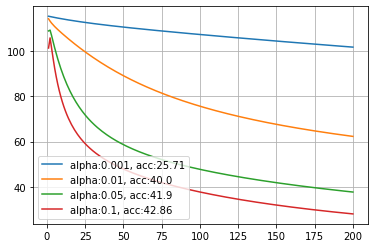

In [22]:
# only did 100 iters for each because TOO LONG
theta_arr = []
cost_arr = []
accuracy_arr = []

# design your own learning rate and num iterations
alpha_arr = np.array([0.001, 0.01, 0.05, 0.1])
iterations_arr = np.array([200, 200, 200, 200])

fig = plt.figure()
ax = plt.axes()
plt.grid(axis='both')


for i in range(0, len(alpha_arr)):
    theta_initial = np.ones((num_class, n))    
    theta, cost = my_gradient_descent(X_train, y_train, theta_initial, alpha_arr[i], iterations_arr[i], num_class)
    
    y_pred = []
    for index,row in X_test.iterrows():
        h_matrix = h(row, theta, num_class)
        prediction = int(np.where(h_matrix == h_matrix.max())[0])    
        y_pred.append(prediction)        
    correct = (y_pred == y_test).value_counts()[True]
    accuracy = correct/m
    plt.plot(range(1,iterations_arr[i]+1), cost, label='alpha:'+str(alpha_arr[i]) +', acc:' + str(np.round(accuracy,4)*100))
    accuracy_arr.append(accuracy)
    
plt.legend()
plt.show()

**Expected result**: <span style="color:blue">(*Yours doesn't have to be the same!*)</span>

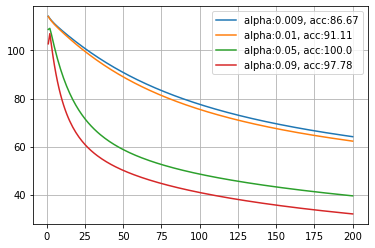

In [23]:
def idx(y_pred,y_test,_class):
    idx_class_pred = []
    idx_class_test = []
    for i in range(len(y_pred)):
        if y_pred[i] == _class:
            idx_class_pred.append(i)
    for j in range(len(y_test)):
        if y_test[j] == _class:
            idx_class_test.append(j)
    return idx_class_pred , idx_class_test

idx_0_pred, idx_0_test = idx(y_pred,y_test,0)
idx_1_pred, idx_1_test = idx(y_pred,y_test,1)
idx_2_pred, idx_2_test = idx(y_pred,y_test,2)

print(idx_0_pred)
print(idx_1_pred)
print(idx_2_pred)

print(idx_0_test)
print(idx_1_test)
print(idx_2_test)

[2, 4, 7, 11, 12, 18, 20, 22, 23, 25, 27, 28, 29, 31, 33, 35, 43]
[0, 5, 8, 14, 16, 17, 19, 34, 38, 40, 42, 44]
[1, 3, 6, 9, 10, 13, 15, 21, 24, 26, 30, 32, 36, 37, 39, 41]
[2, 4, 7, 11, 12, 18, 20, 22, 23, 25, 27, 28, 29, 31, 33, 35, 43]
[0, 5, 8, 14, 16, 17, 19, 34, 38, 40, 42, 44]
[1, 3, 6, 9, 10, 13, 15, 21, 24, 26, 30, 32, 36, 37, 39, 41]


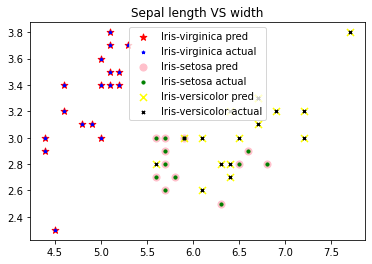

In [24]:
plt.scatter(X_test['SepalLengthCm'].iloc[idx_0_pred],X_test['SepalWidthCm'].iloc[idx_0_pred],s=50, c='red', marker='*', label='Iris-virginica pred')
plt.scatter(X_test['SepalLengthCm'].iloc[idx_0_test],X_test['SepalWidthCm'].iloc[idx_0_test],s=10, c='blue', marker='*', label='Iris-virginica actual')
plt.scatter(X_test['SepalLengthCm'].iloc[idx_1_pred],X_test['SepalWidthCm'].iloc[idx_1_pred],s=50, c='pink', marker='o', label='Iris-setosa pred')
plt.scatter(X_test['SepalLengthCm'].iloc[idx_1_test],X_test['SepalWidthCm'].iloc[idx_1_test],s=10, c='green', marker='o', label='Iris-setosa actual')
plt.scatter(X_test['SepalLengthCm'].iloc[idx_2_pred],X_test['SepalWidthCm'].iloc[idx_2_pred],s=50, c='yellow', marker='x', label='Iris-versicolor pred')
plt.scatter(X_test['SepalLengthCm'].iloc[idx_2_test],X_test['SepalWidthCm'].iloc[idx_2_test],s=10, c='black', marker='x', label='Iris-versicolor actual')
plt.title("Sepal length VS width")
plt.legend(loc='best')

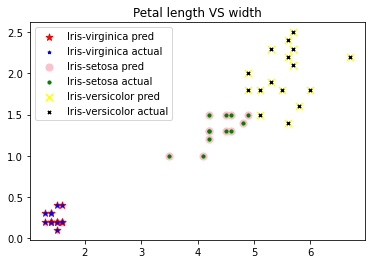

In [25]:
plt.scatter(X_test['PetalLengthCm'].iloc[idx_0_pred],X_test['PetalWidthCm'].iloc[idx_0_pred],s=50, c='red', marker='*', label='Iris-virginica pred')
plt.scatter(X_test['PetalLengthCm'].iloc[idx_0_test],X_test['PetalWidthCm'].iloc[idx_0_test],s=10, c='blue', marker='*', label='Iris-virginica actual')
plt.scatter(X_test['PetalLengthCm'].iloc[idx_1_pred],X_test['PetalWidthCm'].iloc[idx_1_pred],s=50, c='pink', marker='o', label='Iris-setosa pred')
plt.scatter(X_test['PetalLengthCm'].iloc[idx_1_test],X_test['PetalWidthCm'].iloc[idx_1_test],s=10, c='green', marker='o', label='Iris-setosa actual')
plt.scatter(X_test['PetalLengthCm'].iloc[idx_2_pred],X_test['PetalWidthCm'].iloc[idx_2_pred],s=50, c='yellow', marker='x', label='Iris-versicolor pred')
plt.scatter(X_test['PetalLengthCm'].iloc[idx_2_test],X_test['PetalWidthCm'].iloc[idx_2_test],s=10, c='black', marker='x', label='Iris-versicolor actual')
plt.title("Petal length VS width")
plt.legend(loc='best')

## On your own to take home

We see that the Iris dataset is pretty easy. Depending on the train/test split, we get 95-100% accuracy.

Find a more interesting multi-class classification problem on Kaggle (Tell the reference), clean the dataset to obtain numerical input features without missing values,
split the data into test and train, and experiment with multinomial logistic regression.

Write a brief report on your experiments and results. As always, turn in a Jupyter notebook by email
to the instructor and TA.


## REPORT

Dataset from Kaggle - https://www.kaggle.com/aungpyaeap/fish-market

In these experiements, I learned about how generalized linear models can be used to perform multinomial logistic regression to classify data into more than 2 classes. In the class exercises, the Iris data with 3 classes was used for training and prediction and allowed me to obtain a very high accuracy.

In the take-home lab, I, once again, used the fish dataset from Kaggle which classifies 7 different species of fish based on varying lengths, height, width, and weight - 6 features in total. At the end of the experiement, 3 seperate scatter graphs were plotted with each comparing 2 features at a time.

I first started by importing the my same functions used in the class lab. Then I imported the .csv file with the fish data, shuffled the samples, standardized the data, and partitioned it into training and testing samples. As the data was imported in as a pandas Dataframe, I was able to quickly check for missing values with is 'isnull()' method but there were no data cleaning required. The output targets (classes) were all encoded to a number from 0 to 6. Then I performed the training with 4 different learning rates and plot the cost of each across the 200 iterations along with each alpha's accuracy. Finally, I made 3 scatter plots showing the predicted and actual class of each item in the training set, plotting two features at a time.Some features were more successful at predicting the right class than others, but overall, the training done produced a respectable model for fish prediction.

In [26]:
import numpy as np
import pandas as pd 
import random
import math
import matplotlib.pyplot as plt

def phi(i, theta, X, num_class):
    """
    Here is how to make documentation for your function show up in intellisense.
    Explanation you put here will be shown when you use it.
    
    To get intellisense in your Jupyter notebook:
        - Press 'TAB' after typing a dot (.) to see methods and attributes
        - Press 'Shift+TAB' after typing a function name to see its documentation

    The `phi` function returns phi_i = h_theta(x) for input patterns X and parameters theta.
    
    Inputs:
        i=index of phi
        
        X=input dataset
        
        theta=parameters

    Returns:
        phi_i
    """
    mat_theta = np.matrix(theta[i])
    mat_x = np.matrix(X)
    num = math.exp(np.dot(mat_theta, mat_x.T))
    den = 0
    for j in range(0,num_class):
        mat_theta_j = np.matrix(theta[j])
        den = den + math.exp(np.dot(mat_theta_j, mat_x.T))
    phi_i = num / den
    return phi_i

def indicator(i, j):
    '''
    Check whether i is equal to j
    
    Return:
        1 when i=j, otherwise 0
    '''
    if i == j: return 1
    else: return 0
    
def my_J(theta, X, y, j, num_class):
#     print('indicator returns:',indicator(y,j))
#     print('phi returns:', -np.log(phi(j, theta, X, num_class)))
    cost = indicator(y,j)*-np.log(phi(j, theta, X, num_class))
#     print('cost:', cost)
    return cost

def my_grad_cost(X, y, j, theta, num_class):
    
    m, n = X.shape
    sum = np.array([0 for i in range(0,n)])
    cost = 0
    for i in range(0, m):
        p = indicator(y[i], j) - phi(j, theta, X.loc[i], num_class)
        cost = cost + my_J(theta, X.loc[i], y[i],j, num_class)
        sum = sum + (X.loc[i] * p)  
    grad = -sum/m
    return grad, cost

def my_gradient_descent(X, y, theta, alpha, iters, num_class):        
    cost_arr = []
    for iteration in range(iters):
        total_cost = 0
        for j in range(0, num_class):
            grad, cost = my_grad_cost(X, y, j, theta_initial, num_class)
            theta[j] = theta[j] - alpha * grad
            total_cost = total_cost + cost
        cost_arr.append(total_cost)
    return theta, cost_arr

def h(X, theta, num_class):
    '''
    Hypothesis function: h_theta(X) = theta * X
    '''
    X = np.matrix(X)
    h_matrix = np.empty((num_class,1))
    den = 0
    for j in range(0, num_class):
        den = den + math.exp(np.dot(theta[j], X.T))
    for i in range(0,num_class):
        h_matrix[i] = math.exp(np.dot(theta[i], X.T))
    h_matrix = h_matrix / den
    return h_matrix

In [27]:

data = pd.read_csv('Fish.csv')
# print(data.head())

m,n = data.shape
idx = np.arange(0,m)
random.shuffle(idx)
data = data.iloc[idx,:] # randomize data 
data = data.reset_index() # reinsert index from 0 to m
data.drop(['index'], axis=1, inplace=True)
# print(data.head())

# extract y from data
y_label = 'Species';

y = data[y_label];
# y = np.array(y)
print('y.shape:',y.shape)

# extract features from data
X = data.drop(['Species'], axis=1)
print('X\n',X)

X = X.astype(float)

y.shape: (159,)
X
      Weight  Length1  Length2  Length3   Height   Width
0       0.0     19.0     20.5     22.8   6.4752  3.3516
1     110.0     19.0     21.0     22.5   5.6925  3.5550
2       9.8     11.4     12.0     13.2   2.2044  1.1484
3     510.0     40.0     42.5     45.5   6.8250  4.4590
4     140.0     19.0     20.7     23.2   8.5376  3.2944
..      ...      ...      ...      ...      ...     ...
154    32.0     12.5     13.7     14.7   3.5280  1.9992
155   800.0     33.7     36.4     39.6  11.7612  6.5736
156   130.0     20.5     22.5     24.0   5.8560  3.6240
157     9.9     11.3     11.8     13.1   2.2139  1.1659
158   161.0     22.0     23.4     26.7   6.9153  3.6312

[159 rows x 6 columns]


In [28]:
X_mean = np.mean(X,axis=0)
X_std = np.std(X,axis=0)

X_norm = (X - X_mean)/X_std
print(X_norm)

       Weight   Length1   Length2   Length3    Height     Width
0   -1.116227 -0.727266 -0.740994 -0.728122 -0.584125 -0.634269
1   -0.807975 -0.727266 -0.694189 -0.754042 -0.767311 -0.513233
2   -1.088764 -1.489938 -1.536682 -1.557590 -1.583678 -1.945312
3    0.312942  1.380119  1.318435  1.233226 -0.502256  0.024704
4   -0.723906 -0.727266 -0.722272 -0.693560 -0.101433 -0.668307
..        ...       ...       ...       ...       ...       ...
154 -1.026553 -1.379551 -1.377544 -1.427985 -1.273898 -1.439032
155  1.125606  0.747904  0.747411  0.723448  0.653030  1.283024
156 -0.751929 -0.576738 -0.553773 -0.624438 -0.729044 -0.472174
157 -1.088484 -1.499973 -1.555404 -1.566230 -1.581455 -1.934898
158 -0.665058 -0.426211 -0.469524 -0.391150 -0.481122 -0.467889

[159 rows x 6 columns]


In [29]:
m, n = X_norm.shape

percent_train = 0.7
m_train = int(m*percent_train)

X_train = X_norm.iloc[0:m_train, :];
X_test = X_norm.iloc[m_train:, :];

y_train = y[:m_train];
y_test = y[m_train:];
labels = pd.unique(y)

# encoding targets from 0 to 6
i = 0
for label in set(y):
    y_train[y_train == label] = i
    y_test[y_test == label] = i
    i = i + 1
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(y_train)

(111, 6)
(48, 6)
(111,)
(48,)
0      0
1      3
2      1
3      4
4      2
      ..
106    5
107    3
108    0
109    5
110    5
Name: Species, Length: 111, dtype: object


In [30]:
# No cleaning necessary
print('Missing values for train data:\n------------------------\n', X_train.isnull().sum())
print('Missing values for test data \n ------------------------\n', X_test.isnull().sum())
# add intercept of zeros on column 0
X_train.insert(0, "intercept", 1)
X_test.insert(0, "intercept", 1)

Missing values for train data:
------------------------
 Weight     0
Length1    0
Length2    0
Length3    0
Height     0
Width      0
dtype: int64
Missing values for test data 
 ------------------------
 Weight     0
Length1    0
Length2    0
Length3    0
Height     0
Width      0
dtype: int64


In [31]:
# m, n = X_train.shape
# k = len(set(y)) # 7 classes
# theta_initial = np.ones((k,n)) # initialize theta

# alpha = .05
# iterations = 300

# theta, cost = my_gradient_descent(X_train, y_train, theta_initial, alpha, iterations, k)

In [32]:
# plt.plot(range(iterations), cost)

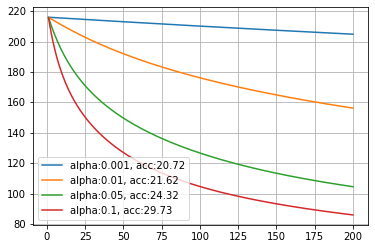

In [33]:
theta_arr = []
cost_arr = []
accuracy_arr = []

m, n = X_train.shape
k = len(set(y)) # 7 classes

# design your own learning rate and num iterations
alpha_arr = np.array([0.001, 0.01, 0.05, 0.1])
iterations_arr = np.array([200, 200, 200, 200])

fig = plt.figure()
ax = plt.axes()
plt.grid(axis='both')


for i in range(0, len(alpha_arr)):
    theta_initial = np.ones((k, n))    
    theta, cost = my_gradient_descent(X_train, y_train, theta_initial, alpha_arr[i], iterations_arr[i], k)
    
    y_pred = []
    for index,row in X_test.iterrows():
        h_matrix = h(row, theta, k)
        prediction = int(np.where(h_matrix == h_matrix.max())[0])    
        y_pred.append(prediction)        
    correct = (y_pred == y_test).value_counts()[True]
    accuracy = correct/m
    plt.plot(range(1,iterations_arr[i]+1), cost, label='alpha:'+str(alpha_arr[i]) +', acc:' + str(np.round(accuracy,4)*100))
    accuracy_arr.append(accuracy)
    
plt.legend()
plt.show()

In [34]:
y_pred1 = np.array(y_pred)
y_test1 = y_test.to_numpy() # CHECK

In [35]:
def idx(y_pred1,y_test1,_class):
    idx_class_pred = []
    idx_class_test = []
    for i in range(len(y_pred1)):
        if y_pred1[i] == _class:
            idx_class_pred.append(i)
    for j in range(len(y_test1)):
        if y_test1[j] == _class:
            idx_class_test.append(j)
    return idx_class_pred , idx_class_test

idx_0_pred, idx_0_test = idx(y_pred1,y_test1,0)
idx_1_pred, idx_1_test = idx(y_pred1,y_test1,1)
idx_2_pred, idx_2_test = idx(y_pred1,y_test1,2)
idx_3_pred, idx_3_test = idx(y_pred1,y_test1,3)
idx_4_pred, idx_4_test = idx(y_pred1,y_test1,4)
idx_5_pred, idx_5_test = idx(y_pred1,y_test1,5)
idx_6_pred, idx_6_test = idx(y_pred1,y_test1,6)

print(idx_0_pred)
print(idx_1_pred)
print(idx_2_pred)
print(idx_3_pred)
print(idx_4_pred)
print(idx_5_pred)
print(idx_6_pred)

print(idx_0_test)
print(idx_1_test)
print(idx_2_test)
print(idx_3_test)
print(idx_4_test)
print(idx_5_test)
print(idx_6_test)

[]
[8, 19, 20, 23, 30, 33, 34, 35, 43, 46]
[11]
[1, 4, 5, 6, 7, 9, 10, 13, 14, 15, 17, 21, 22, 25, 26, 27, 28, 29, 31, 37, 38, 40, 44, 45, 47]
[39, 41, 42]
[0, 2, 3, 12, 16, 18, 24, 32, 36]
[]
[9, 14, 22, 23, 37, 40, 47]
[8, 19, 30, 34, 35, 46]
[0, 11]
[1, 4, 6, 10, 13, 15, 17, 20, 21, 25, 26, 27, 28, 29, 31, 33, 43, 45]
[7, 38, 39, 41, 42]
[2, 3, 12, 16, 18, 24, 32, 36]
[5, 44]


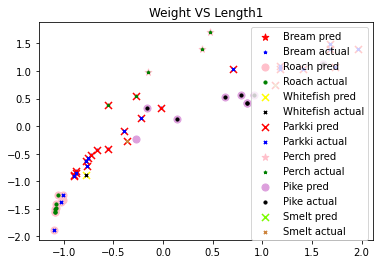

In [36]:
plt.scatter(X_test['Weight'].iloc[idx_0_pred],X_test['Length1'].iloc[idx_0_pred],s=50, c='red', marker='*', label='Bream pred')
plt.scatter(X_test['Weight'].iloc[idx_0_test],X_test['Length1'].iloc[idx_0_test],s=10, c='blue', marker='*', label='Bream actual')
plt.scatter(X_test['Weight'].iloc[idx_1_pred],X_test['Length1'].iloc[idx_1_pred],s=50, c='pink', marker='o', label='Roach pred')
plt.scatter(X_test['Weight'].iloc[idx_1_test],X_test['Length1'].iloc[idx_1_test],s=10, c='green', marker='o', label='Roach actual')
plt.scatter(X_test['Weight'].iloc[idx_2_pred],X_test['Length1'].iloc[idx_2_pred],s=50, c='yellow', marker='x', label='Whitefish pred')
plt.scatter(X_test['Weight'].iloc[idx_2_test],X_test['Length1'].iloc[idx_2_test],s=10, c='black', marker='x', label='Whitefish actual')
plt.scatter(X_test['Weight'].iloc[idx_3_pred],X_test['Length1'].iloc[idx_3_pred],s=50, c='red', marker='x', label='Parkki pred')
plt.scatter(X_test['Weight'].iloc[idx_3_test],X_test['Length1'].iloc[idx_3_test],s=10, c='blue', marker='x', label='Parkki actual')
plt.scatter(X_test['Weight'].iloc[idx_4_pred],X_test['Length1'].iloc[idx_4_pred],s=50, c='pink', marker='*', label='Perch pred')
plt.scatter(X_test['Weight'].iloc[idx_4_test],X_test['Length1'].iloc[idx_4_test],s=10, c='green', marker='*', label='Perch actual')
plt.scatter(X_test['Weight'].iloc[idx_5_pred],X_test['Length1'].iloc[idx_5_pred],s=50, c='plum', marker='o', label='Pike pred')
plt.scatter(X_test['Weight'].iloc[idx_5_test],X_test['Length1'].iloc[idx_5_test],s=10, c='black', marker='o', label='Pike actual')
plt.scatter(X_test['Weight'].iloc[idx_6_pred],X_test['Length1'].iloc[idx_6_pred],s=50, c='lawngreen', marker='x', label='Smelt pred')
plt.scatter(X_test['Weight'].iloc[idx_6_test],X_test['Length1'].iloc[idx_6_test],s=10, c='peru', marker='x', label='Smelt actual')

plt.title("Weight VS Length1")
plt.legend(loc='best')

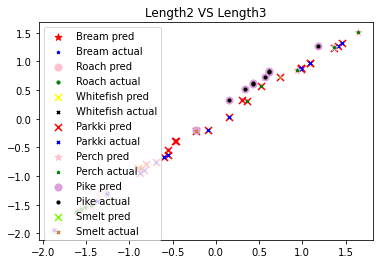

In [37]:
plt.scatter(X_test['Length2'].iloc[idx_0_pred],X_test['Length3'].iloc[idx_0_pred],s=50, c='red', marker='*', label='Bream pred')
plt.scatter(X_test['Length2'].iloc[idx_0_test],X_test['Length3'].iloc[idx_0_test],s=10, c='blue', marker='*', label='Bream actual')
plt.scatter(X_test['Length2'].iloc[idx_1_pred],X_test['Length3'].iloc[idx_1_pred],s=50, c='pink', marker='o', label='Roach pred')
plt.scatter(X_test['Length2'].iloc[idx_1_test],X_test['Length3'].iloc[idx_1_test],s=10, c='green', marker='o', label='Roach actual')
plt.scatter(X_test['Length2'].iloc[idx_2_pred],X_test['Length3'].iloc[idx_2_pred],s=50, c='yellow', marker='x', label='Whitefish pred')
plt.scatter(X_test['Length2'].iloc[idx_2_test],X_test['Length3'].iloc[idx_2_test],s=10, c='black', marker='x', label='Whitefish actual')
plt.scatter(X_test['Length2'].iloc[idx_3_pred],X_test['Length3'].iloc[idx_3_pred],s=50, c='red', marker='x', label='Parkki pred')
plt.scatter(X_test['Length2'].iloc[idx_3_test],X_test['Length3'].iloc[idx_3_test],s=10, c='blue', marker='x', label='Parkki actual')
plt.scatter(X_test['Length2'].iloc[idx_4_pred],X_test['Length3'].iloc[idx_4_pred],s=50, c='pink', marker='*', label='Perch pred')
plt.scatter(X_test['Length2'].iloc[idx_4_test],X_test['Length3'].iloc[idx_4_test],s=10, c='green', marker='*', label='Perch actual')
plt.scatter(X_test['Length2'].iloc[idx_5_pred],X_test['Length3'].iloc[idx_5_pred],s=50, c='plum', marker='o', label='Pike pred')
plt.scatter(X_test['Length2'].iloc[idx_5_test],X_test['Length3'].iloc[idx_5_test],s=10, c='black', marker='o', label='Pike actual')
plt.scatter(X_test['Length2'].iloc[idx_6_pred],X_test['Length3'].iloc[idx_6_pred],s=50, c='lawngreen', marker='x', label='Smelt pred')
plt.scatter(X_test['Length2'].iloc[idx_6_test],X_test['Length3'].iloc[idx_6_test],s=10, c='peru', marker='x', label='Smelt actual')

plt.title("Length2 VS Length3")
plt.legend(loc='best')

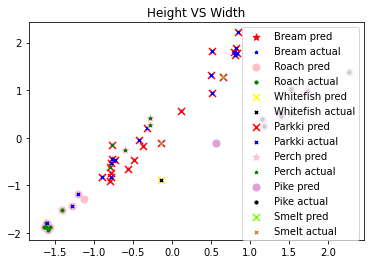

In [38]:
plt.scatter(X_test['Height'].iloc[idx_0_pred],X_test['Width'].iloc[idx_0_pred],s=50, c='red', marker='*', label='Bream pred')
plt.scatter(X_test['Height'].iloc[idx_0_test],X_test['Width'].iloc[idx_0_test],s=10, c='blue', marker='*', label='Bream actual')
plt.scatter(X_test['Height'].iloc[idx_1_pred],X_test['Width'].iloc[idx_1_pred],s=50, c='pink', marker='o', label='Roach pred')
plt.scatter(X_test['Height'].iloc[idx_1_test],X_test['Width'].iloc[idx_1_test],s=10, c='green', marker='o', label='Roach actual')
plt.scatter(X_test['Height'].iloc[idx_2_pred],X_test['Width'].iloc[idx_2_pred],s=50, c='yellow', marker='x', label='Whitefish pred')
plt.scatter(X_test['Height'].iloc[idx_2_test],X_test['Width'].iloc[idx_2_test],s=10, c='black', marker='x', label='Whitefish actual')
plt.scatter(X_test['Height'].iloc[idx_3_pred],X_test['Width'].iloc[idx_3_pred],s=50, c='red', marker='x', label='Parkki pred')
plt.scatter(X_test['Height'].iloc[idx_3_test],X_test['Width'].iloc[idx_3_test],s=10, c='blue', marker='x', label='Parkki actual')
plt.scatter(X_test['Height'].iloc[idx_4_pred],X_test['Width'].iloc[idx_4_pred],s=50, c='pink', marker='*', label='Perch pred')
plt.scatter(X_test['Height'].iloc[idx_4_test],X_test['Width'].iloc[idx_4_test],s=10, c='green', marker='*', label='Perch actual')
plt.scatter(X_test['Height'].iloc[idx_5_pred],X_test['Width'].iloc[idx_5_pred],s=50, c='plum', marker='o', label='Pike pred')
plt.scatter(X_test['Height'].iloc[idx_5_test],X_test['Width'].iloc[idx_5_test],s=10, c='black', marker='o', label='Pike actual')
plt.scatter(X_test['Height'].iloc[idx_6_pred],X_test['Width'].iloc[idx_6_pred],s=50, c='lawngreen', marker='x', label='Smelt pred')
plt.scatter(X_test['Height'].iloc[idx_6_test],X_test['Width'].iloc[idx_6_test],s=10, c='peru', marker='x', label='Smelt actual')

plt.title("Height VS Width")
plt.legend(loc='best')